### - Exercici 1

Crea almenys tres models de regressió diferents per intentar predir el millor possible l’endarreriment dels vols (ArrDelay) de DelayedFlights.csv.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
import seaborn as sns
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.feature_selection import RFE
from sklearn.pipeline import make_pipeline
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

#### Explore, dummies and train test partition

In [2]:
df = pd.read_csv('delayed_flights_clean.csv')
df.drop('Unnamed: 0', axis = 1, inplace = True)
df.sample(10)

,Date,UniqueCarrier,AirTime,Speed,DelayedMinutes,Distance,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
1289064,2008-08-06,XE,71.0,5.492958,39.0,390,0.0,0.0,0.0,0.0,39.0
222259,2008-02-06,XE,84.0,7.821429,0.0,657,0.0,0.0,0.0,0.0,0.0
1185832,2008-07-08,FL,80.0,5.075000,132.0,406,0.0,0.0,132.0,0.0,0.0
1025712,2008-06-05,NW,93.0,4.387097,28.0,408,0.0,0.0,22.0,0.0,6.0
1330557,2008-08-18,UA,93.0,6.763441,0.0,629,0.0,0.0,0.0,0.0,0.0
1841925,2008-12-26,EV,71.0,7.436620,165.0,528,98.0,0.0,67.0,0.0,0.0
974537,2008-06-17,US,49.0,7.285714,62.0,357,5.0,0.0,0.0,0.0,57.0
341132,2008-02-04,AA,170.0,6.894118,16.0,1172,0.0,0.0,2.0,0.0,14.0
1519146,2008-10-04,WN,40.0,5.575000,24.0,223,0.0,0.0,0.0,0.0,24.0
1682043,2008-11-09,EV,22.0,3.772727,0.0,83,0.0,0.0,0.0,0.0,0.0


In [3]:
#Get a stratified train test subsets. Since the dataset is extremely large,
#we train our model with only 15% of the data due to performance issues.
train, test = train_test_split(df, test_size = 0.85,
                              random_state = 1, shuffle = True, stratify = df['UniqueCarrier'])

In [4]:
def dumClean(data):
    dum = pd.get_dummies(data['UniqueCarrier'])
    data.drop(['AirTime', 'UniqueCarrier', 'Date'], axis = 1, inplace = True)
    
    return pd.concat([data, dum], axis = 1)

In [5]:
realTrain = dumClean(train)
realTest = dumClean(test)

#### Rescaling the variables

In [6]:
realTrain.describe().applymap(lambda x: f"{x:0.3f}")

,Speed,DelayedMinutes,Distance,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,9E,AA,...,HA,MQ,NW,OH,OO,UA,US,WN,XE,YV
count,289254.000,289254.000,289254.000,289254.000,289254.000,289254.000,289254.000,289254.000,289254.000,289254.000,...,289254.000,289254.000,289254.000,289254.000,289254.000,289254.000,289254.000,289254.000,289254.000,289254.000
mean,6.614,40.552,764.593,12.297,2.340,9.694,0.056,16.420,0.027,0.099,...,0.004,0.073,0.041,0.027,0.068,0.073,0.051,0.195,0.053,0.035
std,1.347,57.039,574.270,35.793,16.633,27.835,1.516,35.919,0.161,0.299,...,0.062,0.261,0.198,0.163,0.252,0.260,0.220,0.396,0.225,0.183
min,0.600,0.000,30.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,5.861,0.000,338.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
50%,6.729,24.000,606.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
75%,7.467,56.000,992.000,10.000,0.000,6.000,0.000,18.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
max,140.125,1655.000,4962.000,1510.000,1352.000,768.000,229.000,1012.000,1.000,1.000,...,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000


In [7]:
#Rescale the non dummy variables in the test and train subsets
nonDummies = ['Speed', 'Distance', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 
              'SecurityDelay', 'LateAircraftDelay', 'DelayedMinutes']
#build a scaler with xtrain
scaler = RobustScaler().fit(realTrain[nonDummies])
#scale xtrain
realTrain[nonDummies] = scaler.transform(realTrain[nonDummies])
#scale xtest with the same operation scaler as xtrain. This avoids andom skewness.
realTest[nonDummies] = scaler.transform(realTest[nonDummies])

In [8]:
realTrain.describe().applymap(lambda x : f'{x:0.3f}')

,Speed,DelayedMinutes,Distance,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,9E,AA,...,HA,MQ,NW,OH,OO,UA,US,WN,XE,YV
count,289254.000,289254.000,289254.000,289254.000,289254.000,289254.000,289254.000,289254.000,289254.000,289254.000,...,289254.000,289254.000,289254.000,289254.000,289254.000,289254.000,289254.000,289254.000,289254.000,289254.000
mean,-0.072,0.296,0.242,1.230,2.340,1.616,0.056,0.912,0.027,0.099,...,0.004,0.073,0.041,0.027,0.068,0.073,0.051,0.195,0.053,0.035
std,0.839,1.019,0.878,3.579,16.633,4.639,1.516,1.996,0.161,0.299,...,0.062,0.261,0.198,0.163,0.252,0.260,0.220,0.396,0.225,0.183
min,-3.817,-0.429,-0.881,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,-0.541,-0.429,-0.410,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
50%,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
75%,0.459,0.571,0.590,1.000,0.000,1.000,0.000,1.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
max,83.074,29.125,6.661,151.000,1352.000,128.000,229.000,56.222,1.000,1.000,...,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000


#### Simple Linear regression
If we had to choose a single numerical variable to be x, which would be the best choice? Probably the one with the highest correlation coefficient with our target value.

In [9]:
def corrHeatMap(corrMat, ax):
    
    mask = np.triu(corrMat)
    sns.heatmap(corrMat, annot = True, linewidths = 1, mask = mask,
            annot_kws={"size": 10}, cmap = 'Greens', ax = ax)
    ax.set_title('Correlation Matrix Delayed Flights')    
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)

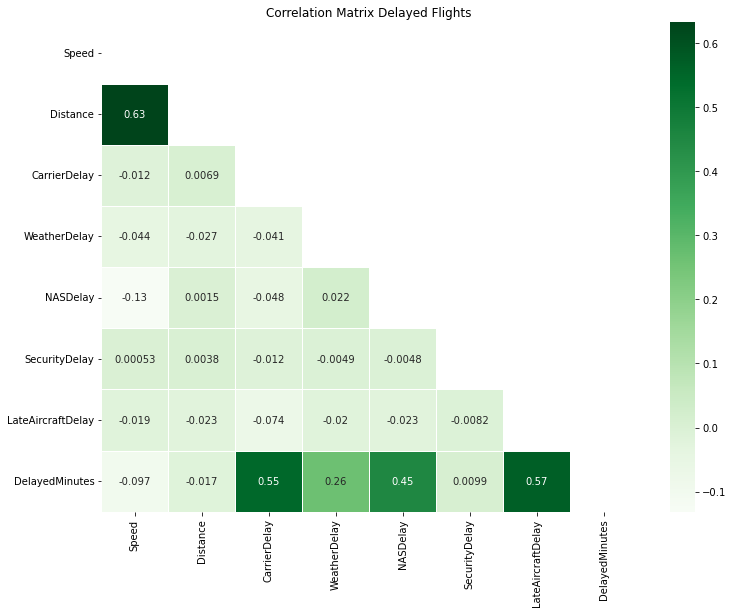

In [10]:
corrMat = realTrain[nonDummies].corr()

fig, ax = plt.subplots(figsize=(12,9))
corrHeatMap(corrMat, ax)

In [11]:
#Split the train and test sets into x and y
def xySplit(data, target):
    y = data.pop(target)
    return data, y

In [12]:
xTrain, yTrain = xySplit(realTrain, 'DelayedMinutes')
xTest, yTest = xySplit(realTest, 'DelayedMinutes')

What if we add another column which will be the sum of all the delays? The answer is that we should have done that before scaling. More on that later, along with PCA. For the moment let's pick LateAircraftDelay.

In [13]:
singleXTrain = np.array(xTrain['LateAircraftDelay']).reshape(-1,1)
singleLR = linear_model.LinearRegression()
singleLR.fit(singleXTrain, yTrain)
slope = singleLR.coef_
print('slopes=',slope)
intercept = singleLR.intercept_
print('b0=', intercept)
r2 = singleLR.score(singleXTrain, yTrain)
print('r2=', r2)

slopes= [0.2895222]
b0= 0.03146823712054869
r2= 0.32173529266777334


In the training subset, the r2 is pretty low. Anyway, for the sake of the exercise, let's try and predict the outcomes.

In [14]:
singleXTest = np.array(xTest['LateAircraftDelay']).reshape(-1,1)
singleYPredict = singleLR.predict(singleXTest)
singleMse = mean_squared_error(yTest, singleYPredict)
print('Mean Squared Error', singleMse)
singleR2 = r2_score(yTest, singleYPredict)
print('r2', singleR2)

Mean Squared Error 0.7308414259834317
r2 0.3119986974666188


Even though the mse is not high, it seems to be relatively high compared to the values, and since the r2 coefficient shows poor fitting, it would be advised to try and build new models.

In [15]:
def singleLRPlot(xTrain, yTrain, xTest, yTest, predictor):
    fig, axs = plt.subplots(figsize = (24,16), ncols = 1, nrows = 2)
    flatAxs = axs.flatten()
    flatAxs[0].scatter(xTrain[predictor], yTrain, label = 'ground truth')
    flatAxs[0].plot(xTrain[predictor], predictedY(slope, intercept, xTrain[predictor]),
                   color = 'green', label = 'prediction')
    flatAxs[0].grid()
    flatAxs[0].set_title('Train subset')
    flatAxs[0].legend(fontsize = 'xx-large')
    
    flatAxs[1].scatter(xTest[predictor], yTest, color = 'green', label = 'ground truth')
    flatAxs[1].plot(xTest[predictor], predictedY(slope, intercept, xTest[predictor]),
                   color = 'blue', label = 'prediction')
    flatAxs[1].grid()
    flatAxs[1].set_title('Test subset')
    flatAxs[1].legend(fontsize = 'xx-large')
    
def predictedY(m, b, x):
    y = m * x + b
    return y

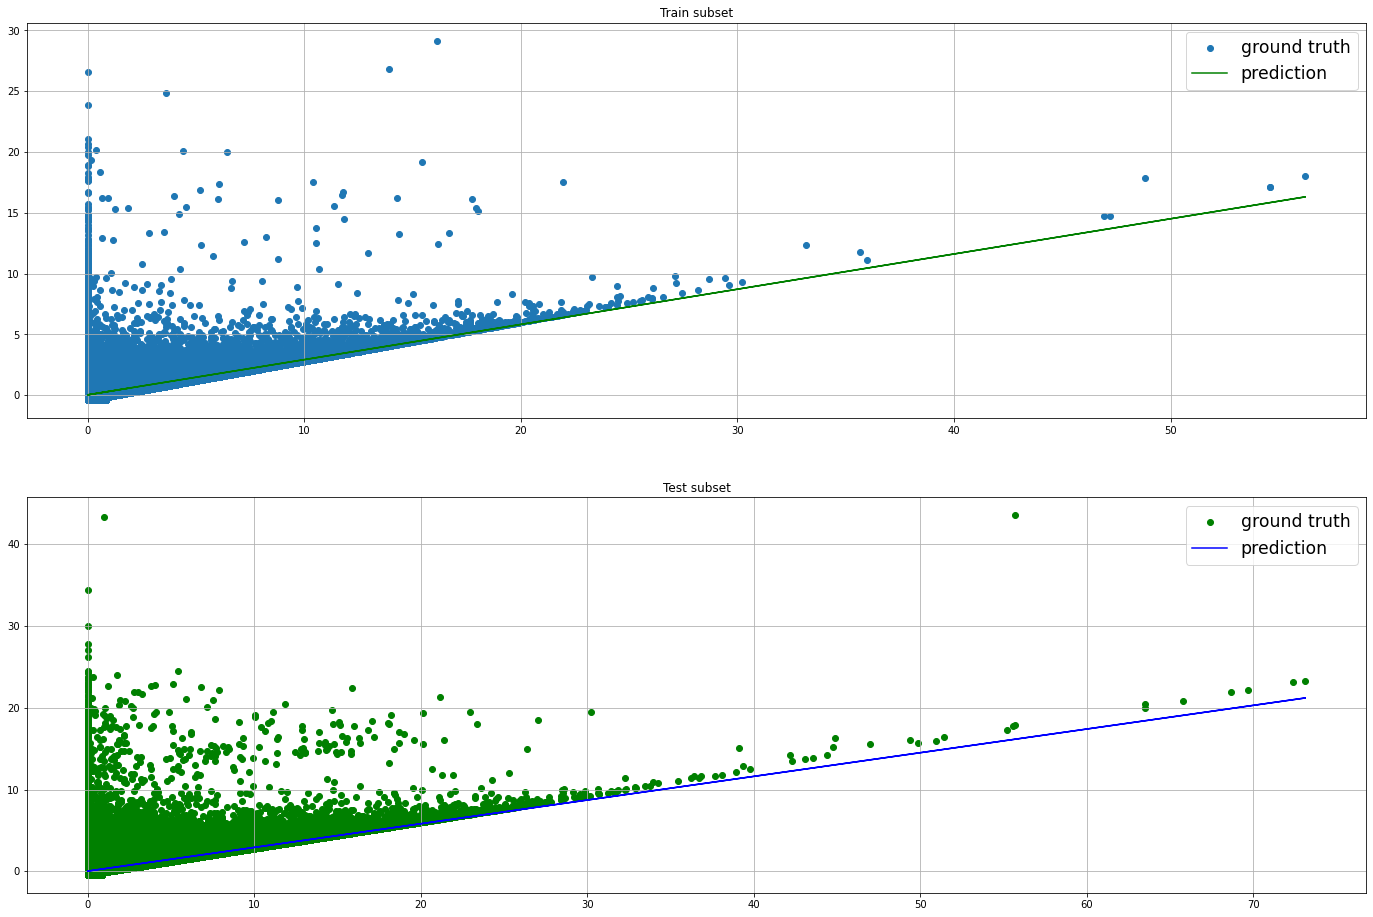

In [16]:
singleLRPlot(xTrain, yTrain, xTest, yTest, 'LateAircraftDelay')

#### Multiple linear regression
Let's try and get a model to take into account all direct causes for delay that show significant correlation with The overall delay.

In [17]:
#set a list of predictors of interest
predictors = ['LateAircraftDelay', 'WeatherDelay', 'NASDelay', 'CarrierDelay']
#Instantiate the model
multipleLR = linear_model.LinearRegression()
#Feed the data to the model
multipleLR.fit(xTrain[predictors], yTrain)
#Show the results
slopes = multipleLR.coef_
print('slopes=',slopes)
intercept = multipleLR.intercept_
print('b0=', intercept)
r2 = multipleLR.score(xTrain[predictors], yTrain)
print('r2=', r2)

slopes= [0.32204099 0.0178819  0.10738284 0.17873154]
b0= -0.43331839470376954
r2= 0.9981459951444438


In [18]:
#Now predict and compare with the test data
LR_y_pred = multipleLR.predict(xTest[predictors])
multiple4Mse = mean_squared_error(yTest, LR_y_pred)
print('Mean Squared Error', multiple4Mse)
multiple4R2 = r2_score(yTest, LR_y_pred)
print('r2', multiple4R2)

Mean Squared Error 0.002040324860626205
r2 0.9980792739549306


That is much better! As one might expect, the overall delay has a linear relationship with its direct causes. Let's use the dummy variables too.

In [19]:
dummyLRmodel = linear_model.LinearRegression()
dummyLRmodel.fit(xTrain, yTrain)
slopes = dummyLRmodel.coef_
print('slopes=',slopes)
intercept = dummyLRmodel.intercept_
print('b0=', intercept)
r2 = dummyLRmodel.score(xTrain, yTrain)
print('r2=', r2)

slopes= [ 2.78519273e-04  2.45408051e-04  1.78828229e-01  1.78910640e-02
  1.07420464e-01  1.78171111e-02  3.22177493e-01  1.01745625e-03
  2.42141198e-04 -3.84017055e-03 -7.57394488e-05  2.46273173e-04
  4.13680741e-04  5.73315494e-04  8.01198504e-04 -7.22726981e-04
 -3.30718439e-04 -5.91910225e-04  2.91512903e-04  7.60274770e-04
  6.14565498e-05  1.13993598e-04  2.20798916e-04  1.66495842e-04
  1.45266593e-04  2.50848587e-04  2.56552533e-04]
b0= -0.43494346459034383
r2= 0.9988494482525637


In [20]:
dummyLR_y_pred = dummyLRmodel.predict(xTest)
dummyMse = mean_squared_error(yTest, dummyLR_y_pred)
print('Mean Squared Error', dummyMse)
dummyR2 = r2_score(yTest, dummyLR_y_pred)
print('r2', dummyR2)

Mean Squared Error 0.0011816802507481406
r2 0.9988875869336515


We achieve a slightly better fit. However, feeding too much variables can induce overfitting, and also, more variables mean more computing time.

#### Overfitting, number of variables and cross validation
To avoid overfitting, we follow a cv scheme, so that we partition our training set into multiple samples (folds) and fit a model with those reduced sets of data. This ensures that our model is less dependent on the set/train partition and more general. Also, for each cv scheme we can use different approaches, as changing the number of variables, and see which is working better to optimise fit and computing time.

In [21]:
nFeatures = xTrain.shape[1]
#27

In [22]:
#Create cv scheme
folds = KFold(n_splits = 5, shuffle = True, random_state = 1)
#range of hyperparameters (number of Features). build it as a dict
hyperParams = [{'n_features_to_select' : list(range(1, nFeatures + 1))}]

#build a simple model and feed the data
LR = linear_model.LinearRegression()
LR.fit(xTrain, yTrain)
#call the recursive feature elimination and feed the model to it
#https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html
rfe = RFE(LR)

#instantiate the model resulting from cross validation
#With refit r2 refits the estimator using the whole dataset
model_cv = GridSearchCV(estimator = rfe, param_grid = hyperParams,
                     scoring = ['r2', 'neg_mean_squared_error'], refit = 'r2',
                     cv = folds, verbose = 1, return_train_score = True)

#fit the model by feeding the data
model_cv.fit(xTrain, yTrain)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
             estimator=RFE(estimator=LinearRegression()),
             param_grid=[{'n_features_to_select': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                   10, 11, 12, 13, 14, 15, 16,
                                                   17, 18, 19, 20, 21, 22, 23,
                                                   24, 25, 26, 27]}],
             refit='r2', return_train_score=True,
             scoring=['r2', 'neg_mean_squared_error'], verbose=1)

In [23]:
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_features_to_select,params,split0_test_r2,split1_test_r2,split2_test_r2,split3_test_r2,...,mean_test_neg_mean_squared_error,std_test_neg_mean_squared_error,rank_test_neg_mean_squared_error,split0_train_neg_mean_squared_error,split1_train_neg_mean_squared_error,split2_train_neg_mean_squared_error,split3_train_neg_mean_squared_error,split4_train_neg_mean_squared_error,mean_train_neg_mean_squared_error,std_train_neg_mean_squared_error
0,3.740197,0.077307,0.013170,0.001172,1,{'n_features_to_select': 1},0.322262,0.320533,0.320270,0.321537,...,-0.703685,0.003247,27,-0.702188,-0.703818,-0.703626,-0.704608,-0.704113,-0.703670,0.000812
1,3.828954,0.059930,0.015202,0.001995,2,{'n_features_to_select': 2},0.656226,0.668588,0.688377,0.658526,...,-0.343229,0.012710,26,-0.339045,-0.343294,-0.348359,-0.340959,-0.344455,-0.343222,0.003178
2,3.676138,0.040880,0.015159,0.001163,3,{'n_features_to_select': 3},0.902271,0.909178,0.922974,0.910565,...,-0.090163,0.008175,25,-0.087120,-0.089206,-0.092762,-0.089635,-0.092081,-0.090161,0.002044
3,3.664221,0.065450,0.014362,0.001352,4,{'n_features_to_select': 4},0.997854,0.998317,0.998262,0.998308,...,-0.001923,0.000205,24,-0.001843,-0.001969,-0.001954,-0.001968,-0.001883,-0.001923,0.000051
4,3.688249,0.095140,0.013564,0.000798,5,{'n_features_to_select': 5},0.998837,0.998867,0.998814,0.998835,...,-0.001194,0.000029,13,-0.001188,-0.001199,-0.001185,-0.001192,-0.001205,-0.001194,0.000007
5,3.633592,0.124451,0.016149,0.002466,6,{'n_features_to_select': 6},0.998837,0.998867,0.998814,0.998835,...,-0.001194,0.000029,16,-0.001188,-0.001199,-0.001185,-0.001192,-0.001205,-0.001194,0.000007
6,3.660403,0.201960,0.015964,0.001899,7,{'n_features_to_select': 7},0.998837,0.998867,0.998814,0.998835,...,-0.001194,0.000029,18,-0.001188,-0.001199,-0.001185,-0.001192,-0.001205,-0.001194,0.000007
7,3.524188,0.116165,0.016155,0.001463,8,{'n_features_to_select': 8},0.998837,0.998867,0.998814,0.998835,...,-0.001194,0.000029,22,-0.001188,-0.001199,-0.001185,-0.001192,-0.001205,-0.001194,0.000007
8,3.315856,0.079710,0.015958,0.003024,9,{'n_features_to_select': 9},0.998837,0.998867,0.998814,0.998835,...,-0.001194,0.000029,21,-0.001188,-0.001199,-0.001185,-0.001192,-0.001205,-0.001194,0.000007
9,3.204545,0.088667,0.015360,0.001353,10,{'n_features_to_select': 10},0.998837,0.998867,0.998814,0.998835,...,-0.001194,0.000029,23,-0.001188,-0.001199,-0.001185,-0.001192,-0.001205,-0.001194,0.000007


Text(0, 0.5, 'Score')

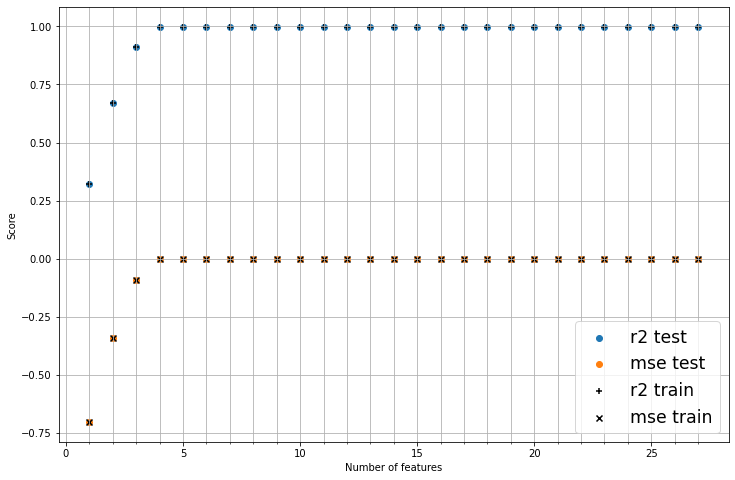

In [24]:
#Display of number of features and mean scores
fig, ax = plt.subplots(figsize = (12,8))

ax.scatter(cv_results['param_n_features_to_select'], cv_results['mean_test_r2'],
          label = 'r2 test')
ax.scatter(cv_results['param_n_features_to_select'], 
           cv_results['mean_test_neg_mean_squared_error'], label = 'mse test')
ax.scatter(cv_results['param_n_features_to_select'], cv_results['mean_train_r2'], 
           marker = '+', color = 'black', label = 'r2 train')
ax.scatter(cv_results['param_n_features_to_select'], 
           cv_results['mean_train_neg_mean_squared_error'], marker = 'x', 
           color = 'black', label = 'mse train')
ax.set_xticks(cv_results['param_n_features_to_select'], minor = True)
ax.grid( which = 'both')
ax.legend(fontsize = 'xx-large')
ax.set_xlabel('Number of features')
ax.set_ylabel('Score')

So we were lucky, and our r2 and mse appear to be on the same scale. Also, fortunately, both achieve optimal values with the same hyperparameter. Otherwise, we may need to display a separate graphic for each score or use a y axis on the right side of the figure, and then build some kind of test that maximizes r2 and minimizes mse to pick the optimal hyperparameter.
Conclusion: r2 and mse both appear to be optimised at 4 predictors or features. Let's look at the actual values in a table and then let the algorithm decide which is the best fit.  
{{cv_results[['mean_test_neg_mean_squared_error', 'std_test_neg_mean_squared_error', 'mean_test_r2', 'std_test_r2']]}}  
This table shows that after the 5th variable, further variables do not change the scores, at least to the 6th decimal. The correct assessment would be to use the model with 5 variables at index 4.

In [25]:
print('best index in cv_results:', model_cv.best_index_)
print('Multimetric?', model_cv.multimetric_)

best index in cv_results: 25
Multimetric? True


We want a different estimator other than best_estimator_. I have found no other way of selecting another estimator other than manually building it. Basically we want to split the data into 5 folds, and iterate over them fitting the best model for each combination of folds. Then we should take the average. However, since we cannot access the estimator object from the GridSearchCV object, we do not know which 5 predictors were used out of the 27 available. We will have to perform RFE again.

In [26]:
#folds = KFold(n_splits = 5, shuffle = True, random_state = 1) this was created before
hyperParams = [{'n_features_to_select' : [5]}]
finalLR = linear_model.LinearRegression()
finalLR.fit(xTrain, yTrain)
finalRfe = RFE(finalLR)

finalModel = GridSearchCV(estimator = finalRfe, param_grid = hyperParams, 
                         scoring = ['r2', 'neg_mean_squared_error'], refit = 'r2',
                         cv = folds, verbose = 1, return_train_score = True)
finalModel.fit(xTrain, yTrain)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
             estimator=RFE(estimator=LinearRegression()),
             param_grid=[{'n_features_to_select': [5]}], refit='r2',
             return_train_score=True, scoring=['r2', 'neg_mean_squared_error'],
             verbose=1)

In [27]:
resultsDf = pd.DataFrame(finalModel.cv_results_)
resultsDf[['mean_test_r2', 'mean_test_neg_mean_squared_error']]

,mean_test_r2,mean_test_neg_mean_squared_error
0,0.998849,-0.001194


In [28]:
print('Scores for 25 predictors:\nr2:', model_cv.best_score_,
     'mse:', cv_results.iloc[model_cv.best_index_].loc['mean_test_neg_mean_squared_error'])
print('Scores with 5 predictors:\nr2:', finalModel.best_score_,
     'mse:', resultsDf.iloc[0].loc['mean_test_neg_mean_squared_error'])

Scores for 25 predictors:
r2: 0.9988492157245172 mse: -0.0011938798839610943
Scores with 5 predictors:
r2: 0.9988491807256716 mse: -0.001193915275182539


On the light of the information given, I believe it is justified to go for the 5 predictors approach. It is a shame GridSearchCV does not retain the fitted models, but on the other hand, depending on the nature of the model, memory usage can become a problem. Knowing that we can analyze the scores and rebuild the model of our choice is a compromise that has proved effective.  
With our 5 predictor model already trained, we should feed it the xTest data, make a prediction and compare with yTest to make a final assessment.

In [29]:
print('Multimetric?', finalModel.multimetric_)
finalEstimator = finalModel.best_estimator_ #This is an RFE object
#We can access the name of the predictors or features that were used
predictorLabels = list(filter(None, list(finalEstimator.support_ * xTrain.columns)))
print('Predictors:', predictorLabels)

#we can access the estimator inside the RFE and its properties completely
finalLR = finalEstimator.estimator_
print(finalLR.coef_)
print(finalLR.intercept_)
print('r2:',finalLR.score(xTrain[predictorLabels], yTrain))

Multimetric? True
Predictors: ['CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay']
[0.17883233 0.01789082 0.10741535 0.01781711 0.32216812]
-0.43463510825409923
r2: 0.9988492111647118


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


You may have noticed the r2 is slightly different than the mean one. This is because the mean r2 is not necessarily the same r2 we get when we apply the model to the whole train test. With all that in mind, let's make a prediction for the test subset.

In [30]:
predictedY = finalLR.predict(xTest[predictorLabels])
finalR2 = r2_score(yTest, predictedY)
print('r2:', finalR2)
finalMse = mean_squared_error(yTest, predictedY)
print('mse:', finalMse)

r2: 0.9988875148521723
mse: 0.001181756820561174


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


In [31]:
recap = pd.DataFrame.from_dict({'Single LR' : [singleR2, singleMse],
             'Multiple 4' : [multiple4R2, multiple4Mse],
             'Multiple 27' : [dummyR2, dummyMse],
             'Cross-Validated' : [finalR2, finalMse]})
recap.set_axis(['r2', 'mse'], axis = 0, inplace = True)

In [32]:
recap

,Single LR,Multiple 4,Multiple 27,Cross-Validated
r2,0.311999,0.998079,0.998888,0.998888
mse,0.730841,0.002040,0.001182,0.001182


In the end, we have a model that using 5 variables gets the same scores (or very similar ones) as the model using 27. Also since we have run a cross validation scheme, there should be no risk of overfitting. Even though running the cross validation scheme with RFE consumes large amounts of time, we now have a reliable model that can be applied to any further data inputs. We could also use the 4 variables approach, but keep in mind that every dataset is unique, so there's no guarantee we can 'guess' a fairly accurate hyperparameter every time.  
#### Particular insights
In this particular dataset, we can consider that delays in flights are mainly related to the direct causes of the delay, but it is not proven whether Carriers affect these results. On one hand, the UniqueCarrier variable has little relevance on our model, but on the other hand, causes of delay may have high correlation with the variable UniqueCarrier. Further analysis to prove or discard the hypothesis should be conducted (for example fitting a model for each carrier and comparing the coefficients or predictions, calculating the correlation coefficient between each Carrier and the delays...).    
We can however, discard the speed, the distance and airtime of the flight, since the correlation matrix showed a low value between these three variables and the direct causes of the delay.

#### Decision Tree

In [68]:
from sklearn.tree import DecisionTreeRegressor

#We already have our train test split so we just have to instantiate the model, and let's 
#use only the 5 predictors approach.
dtr = DecisionTreeRegressor()
hyperParams = [{'max_depth' : list(range(2,30))}]
#predictorLabels is previoudly built with the 5 labels of most important features.
#dtr.fit(xTrain[predictorLabels], yTrain)
#folds = KFold(n_splits = 5, shuffle = True, random_state = 1) previously declared
dtrModel = GridSearchCV(estimator = dtr, param_grid = hyperParams, 
                         scoring = ['r2', 'neg_mean_squared_error'], refit = 'r2',
                         cv = folds, verbose = 1, return_train_score = True)
dtrModel.fit(xTrain[predictorLabels], yTrain)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
             estimator=DecisionTreeRegressor(),
             param_grid=[{'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                        14, 15, 16, 17, 18, 19, 20, 21, 22, 23,
                                        24, 25, 26, 27, 28, 29]}],
             refit='r2', return_train_score=True,
             scoring=['r2', 'neg_mean_squared_error'], verbose=1)

In [73]:
cv_results = pd.DataFrame(dtrModel.cv_results_)
cv_results[['param_max_depth','mean_test_neg_mean_squared_error', 
            'mean_train_neg_mean_squared_error', 'mean_test_r2', 
            'mean_train_r2', 'mean_fit_time']].set_axis(['depth', 'mean_mse_test',
                                        'mean_mse_train', 'mean_r2_test',
                                        'mean_r2_train', 'time'], axis = 1, inplace = False)

,depth,mean_mse_test,mean_mse_train,mean_r2_test,mean_r2_train,time
0,2,-0.579308,-0.578928,0.441632,0.441976,0.064827
1,3,-0.382506,-0.375091,0.631338,0.638454,0.085571
2,4,-0.261000,-0.256787,0.748434,0.752485,0.104939
3,5,-0.176828,-0.173015,0.829554,0.833233,0.120487
4,6,-0.111034,-0.105487,0.892974,0.898324,0.143226
5,7,-0.064329,-0.058017,0.937998,0.944079,0.161982
6,8,-0.042873,-0.036159,0.958679,0.965148,0.184708
7,9,-0.029835,-0.023115,0.971249,0.977720,0.214730
8,10,-0.020600,-0.013967,0.980150,0.986538,0.210856
9,11,-0.016026,-0.009473,0.984558,0.990869,0.223411


Text(0, 0.5, 'Score')

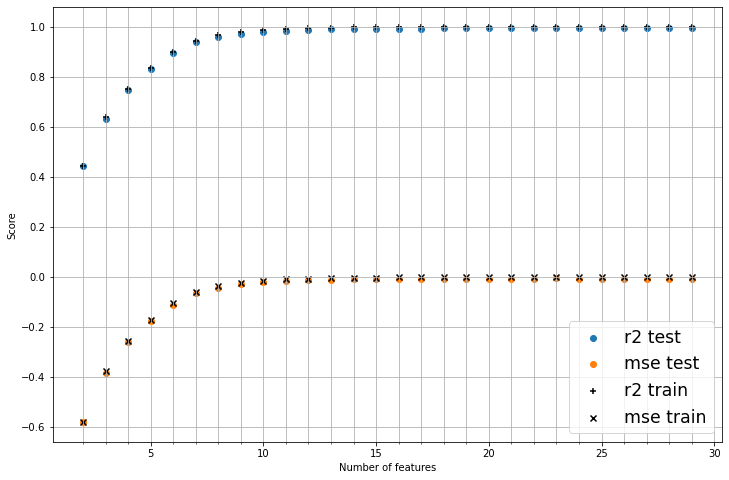

In [71]:
#Display of number of features and mean scores
fig, ax = plt.subplots(figsize = (12,8))

ax.scatter(cv_results['param_max_depth'], cv_results['mean_test_r2'],
          label = 'r2 test')
ax.scatter(cv_results['param_max_depth'], 
           cv_results['mean_test_neg_mean_squared_error'], label = 'mse test')
ax.scatter(cv_results['param_max_depth'], cv_results['mean_train_r2'], 
           marker = '+', color = 'black', label = 'r2 train')
ax.scatter(cv_results['param_max_depth'], 
           cv_results['mean_train_neg_mean_squared_error'], marker = 'x', 
           color = 'black', label = 'mse train')
ax.set_xticks(cv_results['param_max_depth'], minor = True)
ax.grid( which = 'both')
ax.legend(fontsize = 'xx-large')
ax.set_xlabel('Number of features')
ax.set_ylabel('Score')

It's the same case as in the linear regression. Both scores improve with the same tendency ( luckily) of deeper forest, more accurate results. There is also a stationary point where more depth does not improve significantly the fit, but certainly adds performance time (see table above). Let's test the model

In [ ]:
finalDtr = dtrModel.best_estimator_
dtrY = finalDtr.predict(xTest[predictorLabels])

dtrR2 = r2_score(dtrY, yTest)
print('r2:', dtrR2)
dtrMse = mean_squared_error(dtrY, yTest)
print('mse', dtrMse)

### - Exercici 2

Compara’ls en base al MSE i al R2 .

In [86]:
dtrCv = pd.Series([dtrR2, dtrMse], name = 'dtrCV').set_axis(['r2', 'mse'], axis = 0)

finalRecap = pd.concat([recap, dtrCv], axis = 1)
finalRecap.set_axis(['Single LR', 'LR 4', 'LR 27', 'LR 5 CV', 'Decision Tree 5 CV'], 
                    axis = 1, inplace = True)
finalRecap

r2: 0.992751720687781
mse 0.007514718203973634


,Single LR,LR 4,LR 27,LR 5 CV,Decision Tree 5 CV
r2,0.311999,0.998079,0.998888,0.998888,0.992752
mse,0.730841,0.002040,0.001182,0.001182,0.007515




We could explore deeper trees, for example in the 10e4 order.

In [90]:
dtr = DecisionTreeRegressor()
hyperParams = [{'max_depth' : list(range(1,110000,10000))}]
#predictorLabels is previoudly built with the 5 labels of most important features.
#dtr.fit(xTrain[predictorLabels], yTrain)
#folds = KFold(n_splits = 5, shuffle = True, random_state = 1) previously declared
dtrModel = GridSearchCV(estimator = dtr, param_grid = hyperParams, 
                         scoring = ['r2', 'neg_mean_squared_error'], refit = 'r2',
                         cv = folds, verbose = 1, return_train_score = True)
dtrModel.fit(xTrain[predictorLabels], yTrain)

Fitting 5 folds for each of 11 candidates, totalling 55 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
             estimator=DecisionTreeRegressor(),
             param_grid=[{'max_depth': [1, 10001, 20001, 30001, 40001, 50001,
                                        60001, 70001, 80001, 90001, 100001]}],
             refit='r2', return_train_score=True,
             scoring=['r2', 'neg_mean_squared_error'], verbose=1)

In [91]:
cv_results = pd.DataFrame(dtrModel.cv_results_)
cv_results[['param_max_depth','mean_test_neg_mean_squared_error', 
            'mean_train_neg_mean_squared_error', 'mean_test_r2', 
            'mean_train_r2', 'mean_fit_time']].set_axis(['depth', 'mean_mse_test',
                                        'mean_mse_train', 'mean_r2_test',
                                        'mean_r2_train', 'time'], axis = 1, inplace = False)

,depth,mean_mse_test,mean_mse_train,mean_r2_test,mean_r2_train,time
0,1,-0.806030,-8.058084e-01,0.223073,0.223287,0.047698
1,10001,-0.006901,-5.533199e-26,0.993356,1.000000,0.350036
2,20001,-0.006861,-5.533199e-26,0.993391,1.000000,0.345487
3,30001,-0.006605,-5.533199e-26,0.993639,1.000000,0.341709
4,40001,-0.006592,-5.533199e-26,0.993652,1.000000,0.366945
5,50001,-0.006945,-5.533199e-26,0.993314,1.000000,0.348868
6,60001,-0.007141,-5.533199e-26,0.993125,1.000000,0.353854
7,70001,-0.006611,-5.533199e-26,0.993633,1.000000,0.337105
8,80001,-0.006629,-5.533199e-26,0.993619,1.000000,0.336282
9,90001,-0.006637,-5.533199e-26,0.993609,1.000000,0.335721


In [92]:
finalDtr = dtrModel.best_estimator_
dtrY = finalDtr.predict(xTest[predictorLabels])

dtrR2 = r2_score(dtrY, yTest)
print('r2:', dtrR2)
dtrMse = mean_squared_error(dtrY, yTest)
print('mse', dtrMse)

r2: 0.9924637020071727
mse 0.007821197244111688


However, we find very little improvement in the scores, even a slight worsening in the 4th decimal when comparing the test results.